# Field-Keypoints Detection Model Local Training

This notebook trains a YOLOv8x model for football field keypoints detection using your local GPU.

In [1]:
# Install required packages
!pip install ultralytics 
!pip install roboflow

  Using cached roboflow-1.1.61-py3-none-any.whl.metadata (9.7 kB)
  Using cached idna-3.7-py3-none-any.whl.metadata (9.9 kB)
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached python_dotenv-1.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
  Using cached filetype-1.2.0-py2.py3-none-any.whl.metadata (6.5 kB)
Using cached roboflow-1.1.61-py3-none-any.whl (85 kB)
Using cached idna-3.7-py3-none-any.whl (66 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.9 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 8.2 MB/s eta 0:00:00a 0:00:01
Using cached filetype-1.2.0-py2.py3-none-any.whl (19 kB)
Using cached python_dotenv-1.1.0-py3-none-any.whl (20 kB)
Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl (54 kB)
  Attempting uninstall: idna
    Found existing installati

## Imports

In [19]:
from roboflow import Roboflow
from ultralytics import YOLO
import torch
from pathlib import Path
from IPython.display import Image, display
from PIL import Image as PILImage

In [3]:
# Check for GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

if device == "cuda":
    print(f"GPU Information: {torch.cuda.get_device_name(0)}")
    print(f"Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("No GPU detected. Training will be slower on CPU.")

Using device: cuda
GPU Information: NVIDIA A100 80GB PCIe
Available GPU memory: 85.03 GB


## Download Dataset

Download the football players detection dataset from Roboflow.

In [4]:
import roboflow

rf = roboflow.Roboflow(api_key="KBEdRbRsorBypu3bIuO2")

project = rf.workspace("roboflow-jvuqo").project("football-field-detection-f07vi")
version = project.version(12)

print(project)

loading Roboflow workspace...
loading Roboflow project...
{
  "name": "football-field-detection",
  "type": "keypoint-detection",
  "workspace": "roboflow-jvuqo"
}


In [7]:
try:
    # Download dataset from Roboflow (using the same project as in Kaggle)
    print("Downloading dataset from Roboflow...")
    rf = roboflow.Roboflow(api_key="KBEdRbRsorBypu3bIuO2")
    print("Connected to Roboflow")
    project = rf.workspace("roboflow-jvuqo").project("football-field-detection-f07vi")
    print(f"Found project: {project.name}")
    version = project.version(12)
    print(f"Using version: {version.id}")
    dataset = version.download("yolov8", location="/home/asa/cvProj/foot/field-detection-dataset")
    print("Dataset downloaded successfully")
except Exception as e:
    print(f"Error downloading dataset: {e}")

Connected to Roboflow
loading Roboflow workspace...
loading Roboflow project...
Found project: football-field-detection
Using version: roboflow-jvuqo/football-field-detection-f07vi/12



Extracting Dataset Version Zip to /home/asa/cvProj/foot/field-detection-dataset in yolov8:: 100%|██████████| 564/564 [00:00<00:00, 2900.77it/s]


Dataset downloaded successfully


In [8]:
# check the dataset variable
print(dataset)
print("Dataset details:")
print(f"Name: {dataset.name}")
print(f"Version: {dataset.version}")
print(f"Location: {dataset.location}")

Dataset details:
Name: football-field-detection
Version: 12
Location: /home/asa/cvProj/foot/field-detection-dataset


In [9]:
!sed -i 's|\(train: \).*|\1../train/images|' {dataset.location}/data.yaml
!sed -i 's|\(val: \).*|\1../valid/images|' {dataset.location}/data.yaml

## Train the Model

Initialize and train the YOLOv8x model on the football players detection dataset.

In [21]:
data_yaml_path = Path(dataset.location) / "data.yaml"
models_dir = Path("models")
if not models_dir.exists():
    models_dir.mkdir(parents=True, exist_ok=True)
# Initialize a YOLOv8x-pose model
print("Initializing YOLOv8x-pose model...")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")    
model = YOLO('yolov8x-pose.pt')

# Start training
print("Starting model training...")
results = model.train(
    task="pose",           
    data=str(data_yaml_path),
    epochs=500,
    imgsz=640,              
    batch=48,
    mosaic=0.0,             
    plots=True,            
    device=device,
    project=str(models_dir),
    name="field_detector"
)


Initializing YOLOv8x-pose model...
Using device: cuda
Starting model training...
Ultralytics 8.3.111 🚀 Python-3.10.17 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100 80GB PCIe, 81093MiB)
engine/trainer: task=pose, mode=train, model=yolov8x-pose.pt, data=/home/asa/cvProj/foot/field-detection-dataset/data.yaml, epochs=500, time=None, patience=100, batch=48, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=models, name=field_detector3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show

train: Scanning /home/asa/cvProj/foot/field-detection-dataset/train/labels.cache... 222 images, 0 backgrounds, 0 corrupt: 100%|██████████| 222/222 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1087.4±87.3 MB/s, size: 231.5 KB)


val: Scanning /home/asa/cvProj/foot/field-detection-dataset/valid/labels.cache... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]


Plotting labels to models/field_detector3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 103 weight(decay=0.0), 113 weight(decay=0.000375), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to models/field_detector3
Starting training for 500 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      1/500      35.2G      3.301      11.79     0.7014      5.297      3.205         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all         30         30          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      2/500      35.2G      2.816      11.78     0.7037      4.554       2.84         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all         30         30      0.588          1      0.685      0.419          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      3/500      35.2G      1.247      11.63     0.6936      1.448      1.612         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         30         30      0.351      0.867      0.383      0.205          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      4/500      35.2G     0.7776      11.27     0.6765     0.8264      1.306         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         30         30      0.159          1      0.204     0.0529          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      5/500      35.2G     0.6212      11.18     0.6658      0.537      1.184         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         30         30     0.0833     0.0667    0.00948     0.0027          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      6/500      35.2G     0.5846      10.89     0.6245     0.5202      1.156         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all         30         30          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      7/500      35.3G     0.4771      10.62     0.5921     0.4706      1.089         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         30         30          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      8/500      35.3G     0.5533      10.43     0.5833     0.4609      1.136         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all         30         30          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      9/500      35.4G     0.5655      10.18     0.5665     0.4828      1.181         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all         30         30    0.00137     0.0333    0.00101   0.000101          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     10/500      35.4G     0.5346      10.15     0.5561     0.4824      1.107         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all         30         30          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     11/500      35.4G     0.5524      10.18     0.5143     0.5159      1.122         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

                   all         30         30          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     12/500      35.4G     0.5461      9.634      0.514     0.4942      1.128         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         30         30          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     13/500      35.4G     0.5392      9.574      0.527     0.4469      1.114         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all         30         30          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     14/500      35.4G     0.5732      9.326     0.5106     0.5239      1.124         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

                   all         30         30          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     15/500      35.4G     0.5793      9.173     0.5234     0.4645      1.142         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         30         30          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     16/500      35.4G     0.5166      8.614     0.4888     0.4546      1.102         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         30         30       0.25     0.0333     0.0863     0.0432          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     17/500      35.4G     0.5147       8.51     0.4703     0.4763      1.112         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         30         30     0.0504      0.433     0.0469     0.0171          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     18/500      35.4G     0.4868      8.246     0.4294     0.4432       1.09         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all         30         30          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     19/500      35.4G     0.5372      7.873     0.4283     0.4432      1.089         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

                   all         30         30      0.217      0.167      0.165     0.0352          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     20/500      35.4G      0.605      8.226     0.4047     0.5012      1.158         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         30         30     0.0197        0.3     0.0131    0.00142          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     21/500      35.4G     0.6331      7.297     0.3735     0.5038      1.163         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

                   all         30         30     0.0779      0.167     0.0389     0.0113          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     22/500      35.4G     0.5259      7.411     0.3967     0.4273      1.112         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

                   all         30         30     0.0263        0.2     0.0151    0.00473          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     23/500      35.4G      0.467      7.819     0.4169     0.4099      1.071         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

                   all         30         30     0.0333      0.267     0.0237    0.00724          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     24/500      35.4G     0.5141      6.734     0.3837     0.4141      1.098         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all         30         30     0.0489      0.367     0.0397      0.018          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     25/500      35.4G     0.4746      6.765      0.386     0.4305       1.07         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         30         30      0.346      0.367      0.276      0.119          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     26/500      35.4G     0.4645      6.616     0.3584     0.3851      1.018         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all         30         30      0.127      0.467      0.101     0.0287          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     27/500      35.4G     0.4432      6.495     0.3197      0.376      1.026         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         30         30      0.228        0.6      0.298      0.148     0.0046     0.0333    0.00144   0.000289



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     28/500      35.4G     0.4355      6.118     0.3112     0.3815      1.033         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         30         30      0.217      0.867      0.247      0.116          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     29/500      35.4G     0.3842      6.105     0.3115     0.3649     0.9949         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         30         30      0.263      0.867      0.332      0.196          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     30/500      35.4G      0.489       6.37       0.31     0.3858      1.078         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

                   all         30         30      0.667      0.668      0.687      0.214          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     31/500      35.4G     0.4874      6.166     0.2933     0.4093      1.085         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         30         30      0.818        0.9      0.841      0.732          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     32/500      35.4G     0.4927      6.062     0.2805     0.3992      1.073         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         30         30      0.643      0.901      0.761      0.618          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     33/500      35.4G     0.4209      5.612     0.2591     0.3531      1.047         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

                   all         30         30      0.613      0.951      0.809      0.611          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     34/500      35.4G     0.4694      6.017     0.2704     0.3741      1.028         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         30         30      0.718      0.867      0.867      0.711          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     35/500      35.4G     0.4039      5.782     0.2731     0.3511     0.9845         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         30         30      0.994          1      0.995      0.917          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     36/500      35.4G     0.3838      5.083     0.2838     0.3376     0.9903         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         30         30      0.968      0.967      0.994      0.911          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     37/500      35.4G     0.3751      5.272      0.276     0.3254     0.9821         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         30         30      0.965      0.967      0.988      0.896          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     38/500      35.4G     0.3466      5.425     0.2651     0.3115     0.9536         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         30         30      0.881          1      0.974      0.894          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     39/500      35.4G      0.381      5.066      0.249     0.3153          1         30        640: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.70it/s]

                   all         30         30      0.993          1      0.995      0.856          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     40/500      35.4G     0.3611      4.983     0.2512     0.3063       0.99         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all         30         30          1      0.965      0.992       0.85    0.00676     0.0333    0.00366   0.000732



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     41/500      35.4G     0.3912      5.369     0.2419     0.3344      0.996         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         30         30      0.882          1       0.98      0.922          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     42/500      35.4G     0.3912      4.979     0.2373     0.3241     0.9689         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         30         30      0.959          1      0.995      0.888    0.00565     0.0333    0.00302   0.000604



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     43/500      35.4G     0.3674      4.505     0.2509     0.3143     0.9702         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         30         30      0.996          1      0.995      0.946     0.0416     0.0667     0.0111    0.00168



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     44/500      35.4G     0.3946      4.512     0.2348     0.3214     0.9822         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         30         30      0.995      0.967      0.994      0.871          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     45/500      35.4G      0.366       4.63     0.2357     0.3181      0.982         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         30         30      0.989          1      0.995      0.923      0.351      0.367      0.173     0.0293



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     46/500      35.4G     0.3334      4.804      0.247     0.2985     0.9508         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         30         30      0.982          1      0.995      0.918      0.164      0.167     0.0545     0.0209



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     47/500      35.4G     0.3284      4.476     0.2198     0.2918     0.9401         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all         30         30          1      0.995      0.995      0.852    0.00617     0.0333     0.0032   0.000961



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     48/500      35.4G     0.3316      4.181     0.2247     0.2925     0.9694         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         30         30      0.995          1      0.995      0.872     0.0126     0.0667    0.00702   0.000702



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     49/500      35.4G     0.3546      4.688     0.2313     0.3081     0.9557         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         30         30      0.977          1      0.995       0.88      0.081      0.133     0.0545     0.0194



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     50/500      35.4G     0.3171      4.525     0.2289     0.2787     0.9444         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all         30         30      0.988          1      0.995      0.896     0.0855      0.133     0.0314    0.00696



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     51/500      35.4G     0.3226       3.89     0.2358     0.2881      0.947         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         30         30      0.991          1      0.995       0.92       0.24      0.267      0.123     0.0273



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     52/500      35.4G      0.319      3.632     0.2286     0.2788     0.9394         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         30         30       0.95          1      0.989        0.8     0.0824      0.233     0.0524     0.0129



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     53/500      35.4G     0.3243      4.074     0.2249     0.3039     0.9501         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         30         30      0.988          1      0.995       0.88      0.186        0.2     0.0961     0.0279



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     54/500      35.4G     0.3155      3.752     0.2165     0.2908     0.9489         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         30         30      0.996          1      0.995      0.826     0.0563      0.133     0.0372     0.0142



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     55/500      35.4G     0.3575      4.071     0.2363     0.3243     0.9801         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         30         30      0.925          1       0.98      0.819     0.0972      0.233     0.0652     0.0122



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     56/500      35.4G     0.3477      4.111     0.2196     0.3022     0.9571         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         30         30      0.991          1      0.995      0.898          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     57/500      35.4G     0.3548       4.11     0.2373     0.3301     0.9661         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all         30         30      0.962          1      0.995      0.934       0.48        0.5       0.36      0.106



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     58/500      35.4G     0.3279      3.587     0.2178     0.2969     0.9346         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         30         30      0.937      0.997       0.99      0.826     0.0293     0.0667     0.0164    0.00328



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     59/500      35.4G     0.3098      3.194     0.1996     0.2857      0.942         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         30         30      0.995          1      0.995      0.959      0.238      0.333      0.149     0.0409



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     60/500      35.4G     0.3305      3.558     0.2018      0.299     0.9333         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all         30         30          1      0.994      0.995      0.881      0.517        0.5      0.406     0.0912



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     61/500      35.4G     0.3163      3.864     0.1993     0.3045     0.9382         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         30         30      0.996          1      0.995      0.905     0.0431     0.0333     0.0174    0.00364



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     62/500      35.4G     0.3183      4.545      0.217     0.2896     0.9504         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

                   all         30         30      0.998          1      0.995      0.924      0.432      0.433      0.239     0.0468



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     63/500      35.4G     0.3169       4.11     0.2078     0.2962     0.9327         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         30         30      0.997          1      0.995      0.886      0.465      0.467      0.304     0.0671



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     64/500      35.4G     0.3028       3.13     0.1988     0.2775     0.9446         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         30         30      0.994          1      0.995      0.909      0.199        0.2     0.0674     0.0174



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     65/500      35.4G     0.2889      3.653     0.2186     0.2787     0.9179         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         30         30      0.992          1      0.995      0.903     0.0806      0.167     0.0528     0.0155



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     66/500      35.4G     0.2634      3.377     0.1985     0.2623     0.9004         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all         30         30      0.992          1      0.995      0.885      0.431      0.433      0.375     0.0828



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     67/500      35.4G     0.3127      3.648     0.2124     0.2823      0.938         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         30         30      0.991          1      0.995      0.888      0.283      0.267      0.157     0.0393



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     68/500      35.4G     0.2934       3.32     0.2087     0.2717     0.9246         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         30         30      0.959          1      0.991      0.906      0.289        0.3      0.154     0.0328



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     69/500      35.4G     0.2725      2.935     0.1916     0.2563     0.9301         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         30         30      0.998          1      0.995      0.941      0.632      0.633      0.514      0.173



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     70/500      35.4G     0.2968      3.835     0.1908     0.2569     0.9425         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         30         30      0.998          1      0.995      0.931      0.665      0.667      0.518      0.156



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     71/500      35.4G     0.2974      3.046     0.1944     0.2562     0.9322         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         30         30      0.998          1      0.995      0.947      0.645      0.665      0.535      0.216



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     72/500      35.4G     0.2931      3.449     0.2001     0.2707     0.9226         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         30         30      0.998          1      0.995       0.93      0.432      0.433      0.285      0.139



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     73/500      35.4G     0.2883      3.615     0.2027     0.2632     0.9355         30        640: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

                   all         30         30      0.998          1      0.995       0.94      0.419      0.432      0.352      0.108



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     74/500      35.4G     0.2704      3.054     0.1845     0.2613     0.9304         30        640: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all         30         30      0.998          1      0.995      0.957      0.466      0.467      0.354     0.0773



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     75/500      35.4G     0.2714      3.117     0.1968     0.2534     0.9323         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all         30         30      0.998          1      0.995      0.915      0.799        0.8      0.706      0.259



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     76/500      35.4G     0.2445       2.61     0.1945     0.2463      0.888         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all         30         30      0.998          1      0.995      0.935      0.699        0.7      0.558      0.231



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     77/500      35.4G     0.2572      2.865     0.1866     0.2405     0.9115         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         30         30      0.998          1      0.995      0.946      0.833      0.833      0.778      0.325



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     78/500      35.4G     0.2628      2.742     0.1774     0.2444     0.9123         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         30         30      0.998          1      0.995      0.944      0.665      0.667      0.544      0.184



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     79/500      35.4G     0.2739      2.755     0.1949     0.2478     0.9211         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         30         30      0.998          1      0.995      0.932      0.732      0.733      0.631      0.246



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     80/500      35.4G     0.2671      3.079     0.1942     0.2488     0.9124         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         30         30      0.998          1      0.995      0.949      0.599        0.6      0.475      0.155



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     81/500      35.4G     0.2707      2.941     0.1941     0.2359     0.9113         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all         30         30      0.998          1      0.995      0.943      0.267      0.267      0.128     0.0528



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     82/500      35.4G     0.3134      2.631     0.1842     0.2702     0.9264         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         30         30      0.998          1      0.995      0.913       0.42      0.467      0.265     0.0872



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     83/500      35.4G     0.2645      3.033     0.1912     0.2565     0.9302         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         30         30      0.997          1      0.995      0.899      0.665      0.667      0.503      0.186



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     84/500      35.4G       0.27      2.761     0.1865     0.2492     0.9185         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         30         30      0.998          1      0.995       0.93      0.898        0.9      0.859      0.336



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     85/500      35.4G     0.2678      2.698      0.187     0.2506      0.914         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all         30         30      0.998          1      0.995      0.923      0.632      0.633      0.461      0.143



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     86/500      35.4G     0.3166      2.807     0.1794     0.2585     0.9237         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         30         30      0.998          1      0.995      0.931      0.832      0.833      0.754      0.296



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     87/500      35.4G     0.2923      2.649      0.188     0.2491     0.9116         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         30         30      0.998          1      0.995      0.959      0.499        0.5      0.356     0.0927



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     88/500      35.4G      0.301      3.267     0.1873     0.2545     0.9433         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

                   all         30         30      0.998          1      0.995       0.86      0.499        0.5      0.359      0.112



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     89/500      35.4G     0.2952      3.103     0.1881      0.249     0.9335         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         30         30      0.998          1      0.995      0.936      0.677      0.698      0.588       0.21



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     90/500      35.4G     0.2965      2.721     0.1874     0.2589     0.9314         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         30         30      0.998          1      0.995      0.918      0.832      0.833      0.736      0.268



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     91/500      35.4G     0.2655      2.577      0.189     0.2505     0.9194         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         30         30      0.998          1      0.995      0.927      0.632      0.633        0.5      0.167



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     92/500      35.4G     0.2835      2.447     0.1833     0.2446     0.9309         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         30         30      0.997          1      0.995       0.91      0.533      0.533      0.467      0.124



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     93/500      35.4G     0.2837      2.616     0.1724     0.2483     0.9327         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         30         30      0.998          1      0.995      0.946      0.599        0.6      0.504      0.167



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     94/500      35.4G     0.2609       2.54     0.1721     0.2409     0.9423         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         30         30      0.998          1      0.995      0.957      0.699        0.7      0.575      0.262



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     95/500      35.4G     0.2505      2.298     0.1727     0.2353      0.895         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         30         30      0.998          1      0.995      0.963      0.632      0.633      0.549      0.168



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     96/500      35.4G     0.2554      2.509     0.1695     0.2401     0.9155         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         30         30      0.997          1      0.995      0.936      0.831      0.833      0.786      0.304



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     97/500      35.4G     0.2555      3.314     0.1795     0.2338     0.9216         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         30         30      0.997          1      0.995      0.959      0.963      0.967       0.95      0.364



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     98/500      35.4G     0.2533      2.804     0.1694     0.2396     0.9288         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         30         30      0.998          1      0.995      0.945      0.932      0.933        0.9      0.409



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     99/500      35.4G     0.2416      2.253     0.1743     0.2238     0.9049         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         30         30      0.998          1      0.995      0.942      0.998          1      0.995      0.514



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    100/500      35.4G     0.2405      2.278     0.1674     0.2234     0.9329         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         30         30      0.998          1      0.995      0.929      0.566      0.567       0.46      0.161



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    101/500      35.4G     0.2562       2.34     0.1711     0.2262     0.9131         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         30         30      0.997          1      0.995      0.928      0.898        0.9      0.857       0.34



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    102/500      35.4G     0.2417      2.115     0.1774     0.2242      0.898         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         30         30      0.998          1      0.995      0.948      0.932      0.933      0.932      0.397



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    103/500      35.4G     0.2418       2.11     0.1688     0.2267     0.8992         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         30         30      0.998          1      0.995       0.94      0.632      0.633      0.473       0.11



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    104/500      35.4G     0.2463      2.244      0.175     0.2289     0.9194         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         30         30      0.998          1      0.995      0.947      0.699        0.7      0.543      0.241



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    105/500      35.4G     0.2639      2.861     0.1793     0.2293     0.9112         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         30         30      0.998          1      0.995      0.929      0.765      0.767      0.686      0.248



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    106/500      35.4G     0.2568      2.767     0.1703     0.2306     0.9019         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         30         30      0.998          1      0.995        0.9      0.765      0.767      0.681      0.275



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    107/500      35.4G     0.2603       2.39     0.1764     0.2294     0.9102         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         30         30      0.998          1      0.995      0.939      0.865      0.867      0.824      0.351



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    108/500      35.4G     0.2698      2.634     0.1807     0.2288     0.8963         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         30         30      0.998          1      0.995      0.958      0.865      0.867      0.813      0.395



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    109/500      35.4G     0.2421      2.091     0.1726     0.2229     0.8888         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         30         30      0.998          1      0.995      0.932      0.732      0.733      0.699        0.2



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    110/500      35.4G     0.2383      2.491     0.1817     0.2298     0.8907         30        640: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]

                   all         30         30      0.998          1      0.995      0.948      0.898        0.9      0.907      0.427



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    111/500      35.4G     0.2388      2.451     0.1715     0.2261     0.9023         30        640: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all         30         30      0.998          1      0.995      0.918      0.765      0.767      0.687      0.282



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    112/500      35.4G     0.2547      2.475     0.1814     0.2383     0.8922         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         30         30      0.998          1      0.995      0.937      0.965      0.967      0.962      0.438



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    113/500      35.4G     0.2704       2.27     0.1744     0.2416     0.9057         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         30         30      0.998          1      0.995      0.921      0.998          1      0.995      0.506



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    114/500      35.4G     0.2866      2.186     0.1733      0.249     0.9149         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         30         30      0.998          1      0.995       0.92      0.566      0.567      0.483      0.155



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    115/500      35.4G     0.2576       2.26     0.1797     0.2422     0.8794         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         30         30      0.994          1      0.995      0.917      0.597        0.6      0.474      0.135



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    116/500      35.4G     0.2527      2.262     0.1702      0.233     0.9194         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         30         30      0.995          1      0.995      0.911      0.748        0.8        0.7      0.211



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    117/500      35.4G     0.2372      2.358     0.1754     0.2356      0.895         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         30         30      0.998          1      0.995      0.963      0.699        0.7       0.66      0.225



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    118/500      35.4G      0.241      2.718     0.1692     0.2265     0.8973         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         30         30      0.998          1      0.995      0.928      0.832      0.833      0.811      0.334



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    119/500      35.4G     0.2328      2.287     0.1685      0.226     0.8971         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         30         30      0.998          1      0.995      0.919      0.932      0.933      0.929      0.347



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    120/500      35.4G     0.2396      2.211     0.1695     0.2205     0.8859         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         30         30      0.998          1      0.995      0.943      0.633      0.633      0.662      0.272



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    121/500      35.4G     0.2248      2.271     0.1665     0.2093     0.8887         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         30         30      0.998          1      0.995      0.938      0.932      0.933      0.898      0.423



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    122/500      35.4G      0.237      2.088     0.1647     0.2218     0.8853         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         30         30      0.998          1      0.995      0.949      0.965      0.967      0.961      0.512



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    123/500      35.4G     0.2585      2.155     0.1653     0.2248     0.8874         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         30         30      0.998          1      0.995      0.942      0.765      0.767      0.728      0.256



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    124/500      35.4G     0.2742      2.089     0.1643     0.2372     0.9073         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         30         30      0.998          1      0.995      0.964      0.998          1      0.995       0.45



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    125/500      35.4G     0.2181          2     0.1601     0.2156     0.9033         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         30         30      0.996          1      0.995      0.921      0.996          1      0.995      0.574



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    126/500      35.4G     0.2555      2.175     0.1743     0.2286     0.9022         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         30         30      0.998          1      0.995      0.964      0.832      0.833      0.821      0.316



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    127/500      35.4G     0.2706      2.983     0.1571     0.2301     0.9126         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         30         30      0.998          1      0.995       0.94      0.865      0.867       0.86      0.348



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    128/500      35.4G      0.248       2.33     0.1603      0.218     0.9026         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         30         30      0.998          1      0.995      0.945      0.965      0.967      0.959      0.583



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    129/500      35.4G     0.2527      2.507     0.1665     0.2211     0.9127         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         30         30      0.998          1      0.995      0.944      0.865      0.867      0.849      0.332



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    130/500      35.4G     0.2423      2.442     0.1594     0.2174     0.9001         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         30         30      0.998          1      0.995      0.945      0.865      0.867      0.812      0.391



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    131/500      35.4G     0.2358      2.494     0.1775     0.2129     0.9186         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         30         30          1          1      0.995      0.944      0.933      0.933      0.908      0.347



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    132/500      35.4G      0.214      2.547     0.1689     0.2084     0.8915         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         30         30      0.998          1      0.995      0.953      0.998          1      0.995      0.557



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    133/500      35.4G     0.2264      2.088     0.1669     0.2082     0.8852         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         30         30      0.998          1      0.995      0.937      0.965      0.967      0.954       0.44



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    134/500      35.4G     0.2364      2.391     0.1737     0.2094     0.8995         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         30         30      0.998          1      0.995      0.919      0.965      0.967      0.953      0.512



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    135/500      35.4G     0.2545          2     0.1722     0.2217     0.9101         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         30         30      0.998          1      0.995      0.959      0.965      0.967       0.98      0.473



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    136/500      35.4G     0.2713      2.314     0.1628     0.2301     0.8972         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         30         30      0.998          1      0.995      0.918      0.898        0.9      0.873      0.353



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    137/500      35.4G     0.2834      2.213     0.1654     0.2394     0.8984         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all         30         30      0.998          1      0.995      0.967      0.865      0.867      0.815      0.312



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    138/500      35.4G      0.258      1.995     0.1565     0.2346     0.9066         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         30         30      0.998          1      0.995      0.932      0.965      0.967      0.979      0.463



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    139/500      35.4G     0.2292      2.095     0.1544     0.2162     0.9041         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         30         30      0.998          1      0.995      0.924      0.832      0.833      0.802      0.326



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    140/500      35.4G     0.2188       1.91     0.1635     0.2064     0.9023         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         30         30      0.998          1      0.995       0.92      0.965      0.967      0.949      0.529



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    141/500      35.4G     0.2385      1.729     0.1771     0.2174      0.882         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all         30         30          1          1      0.995      0.951      0.967      0.967      0.975      0.581



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    142/500      35.4G     0.2175      1.919     0.1562     0.2087     0.9127         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         30         30      0.998          1      0.995      0.937      0.799        0.8      0.721      0.288



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    143/500      35.4G     0.2099      2.183     0.1722     0.2112     0.8856         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         30         30      0.998          1      0.995      0.939      0.998          1      0.995      0.558



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    144/500      35.4G     0.2223      1.768     0.1614     0.2088     0.8997         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         30         30      0.998          1      0.995      0.933      0.998          1      0.995      0.579



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    145/500      35.4G     0.2382      1.624     0.1492     0.2154     0.8749         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         30         30      0.998          1      0.995      0.927      0.998          1      0.995      0.657



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    146/500      35.4G     0.2411      1.756     0.1569      0.215     0.8983         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all         30         30      0.998          1      0.995      0.912      0.665      0.667      0.555      0.163



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    147/500      35.4G     0.2341      2.181     0.1714     0.2267      0.894         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         30         30      0.998          1      0.995      0.934      0.965      0.967      0.967      0.542



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    148/500      35.4G     0.2296      1.897     0.1532     0.2127     0.8734         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         30         30          1          1      0.995      0.963      0.967      0.967      0.978      0.487



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    149/500      35.4G     0.2222      2.277     0.1515     0.2071     0.9027         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         30         30          1          1      0.995      0.948        0.7        0.7      0.681      0.398



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    150/500      35.4G     0.2455      1.913     0.1606     0.2137     0.9142         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]

                   all         30         30          1          1      0.995      0.977        0.9        0.9       0.91      0.491



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    151/500      35.4G       0.21      1.821     0.1536     0.2001     0.8861         30        640: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.88it/s]

                   all         30         30      0.998          1      0.995      0.934      0.998          1      0.995      0.533



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    152/500      35.4G     0.2172      1.946     0.1604     0.2032     0.9016         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         30         30      0.998          1      0.995       0.95      0.998          1      0.995      0.554



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    153/500      35.4G     0.2186      1.569     0.1564     0.1994     0.8855         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         30         30      0.998          1      0.995      0.957      0.965      0.967      0.948      0.495



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    154/500      35.4G     0.2207      1.513     0.1523     0.1983     0.8821         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         30         30      0.998          1      0.995      0.967      0.998          1      0.995      0.635



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    155/500      35.4G     0.2103       1.46     0.1537     0.1995      0.881         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         30         30      0.998          1      0.995      0.958      0.899        0.9       0.91      0.404



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    156/500      35.4G     0.2137      1.537     0.1535     0.2035     0.8872         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         30         30      0.998          1      0.995       0.94      0.898        0.9      0.883      0.413



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    157/500      35.4G     0.2168      1.721      0.153     0.2044     0.8947         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         30         30      0.998          1      0.995      0.963      0.699        0.7      0.665      0.288



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    158/500      35.4G     0.2209      1.539     0.1515     0.2033     0.9152         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         30         30      0.998          1      0.995      0.943      0.866      0.867      0.862      0.376



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    159/500      35.4G     0.2149      1.561     0.1434      0.202     0.9085         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         30         30      0.998          1      0.995      0.962      0.965      0.967      0.957      0.451



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    160/500      35.4G     0.2136      1.636     0.1592      0.206     0.8918         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         30         30      0.998          1      0.995      0.962      0.998          1      0.995      0.623



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    161/500      35.4G     0.2306      1.947     0.1554     0.2071     0.8945         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         30         30      0.998          1      0.995      0.959      0.799        0.8      0.779       0.26



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    162/500      35.4G     0.2326      2.532     0.1584     0.2097     0.8842         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         30         30      0.998          1      0.995      0.913      0.965      0.967      0.961      0.517



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    163/500      35.4G     0.2491       2.02     0.1539      0.214      0.905         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         30         30      0.998          1      0.995      0.955      0.865      0.867      0.829      0.395



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    164/500      35.4G     0.2273      2.019      0.155      0.211     0.8867         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         30         30      0.998          1      0.995      0.932      0.965      0.967      0.967      0.534



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    165/500      35.4G     0.2431      1.827     0.1565     0.2064     0.8847         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

                   all         30         30      0.998          1      0.995      0.967      0.899        0.9      0.891      0.396



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    166/500      35.4G     0.2169      1.556     0.1477     0.1983      0.868         48        640:  40%|████      | 2/5 [00:02<00:03,  1.31s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f25d7358c10>
Traceback (most recent call last):
  File "/home/asa/miniconda3/envs/dlcv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/asa/miniconda3/envs/dlcv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
  File "/home/asa/miniconda3/envs/dlcv/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f25d7358c10>
Traceback (most recent call last):
  File "/home/asa/miniconda3/envs/dlcv/lib/python3.10/site-packages/tor

                   all         30         30      0.998          1      0.995      0.956      0.998          1      0.995      0.626



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/5 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f25d7358c10>
Traceback (most recent call last):
  File "/home/asa/miniconda3/envs/dlcv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/asa/miniconda3/envs/dlcv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
  File "/home/asa/miniconda3/envs/dlcv/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f25d7358c10>
Traceback (most recent call last):
  File "/home/asa/miniconda3/envs/dlcv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/asa/miniconda3

                   all         30         30      0.998          1      0.995      0.959      0.732      0.733      0.675      0.297



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    168/500      35.4G     0.1893      1.875     0.1646     0.1957     0.8706         48        640:  20%|██        | 1/5 [00:01<00:05,  1.26s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f25d7358c10>
Traceback (most recent call last):
  File "/home/asa/miniconda3/envs/dlcv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/asa/miniconda3/envs/dlcv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
  File "/home/asa/miniconda3/envs/dlcv/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f25d7358c10>
Traceback (most recent call last):
  File "/home/asa/miniconda3/envs/dlcv/lib/python3.10/site-packages/tor

                   all         30         30      0.998          1      0.995      0.943      0.965      0.967      0.955      0.463



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    169/500      35.4G     0.1965      1.617     0.1547     0.1986     0.8714         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         30         30      0.998          1      0.995       0.96      0.898        0.9      0.899      0.392



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    170/500      35.4G     0.1922      1.737     0.1494     0.1916     0.8827         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         30         30      0.998          1      0.995      0.939      0.932      0.933      0.938      0.397



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    171/500      35.4G     0.1827      1.642     0.1575     0.1919     0.8716         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         30         30      0.998          1      0.995      0.936      0.965      0.967       0.96      0.449



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    172/500      35.4G     0.1906      2.197     0.1535     0.1882      0.879         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         30         30      0.998          1      0.995      0.941      0.998          1      0.995      0.414



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    173/500      35.4G     0.1936      2.137     0.1595     0.1868     0.8946         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         30         30      0.998          1      0.995      0.966      0.998          1      0.995      0.526



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    174/500      35.4G     0.1959      1.778     0.1547     0.1876     0.8757         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         30         30      0.998          1      0.995      0.958      0.965      0.967      0.975      0.458



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    175/500      35.4G     0.2098      1.675     0.1514     0.1887     0.8831         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         30         30      0.998          1      0.995      0.951      0.932      0.933      0.926      0.571



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    176/500      35.4G     0.2367      1.761     0.1406     0.2035     0.9059         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all         30         30          1          1      0.995       0.95      0.967      0.967      0.955      0.524



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    177/500      35.4G     0.2401      1.484     0.1507     0.2089     0.9013         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all         30         30      0.998          1      0.995      0.962      0.998          1      0.995      0.665



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    178/500      35.4G      0.216      1.476     0.1515      0.201     0.8807         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         30         30      0.998          1      0.995      0.939      0.965      0.967      0.958      0.638



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    179/500      35.4G     0.2015      1.349     0.1529     0.1985     0.8883         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         30         30          1          1      0.995      0.978          1          1      0.995      0.678



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    180/500      35.4G     0.1987      1.373     0.1475     0.1946     0.8719         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         30         30          1          1      0.995      0.933          1          1      0.995      0.689



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    181/500      35.4G     0.2028      1.534     0.1555      0.199     0.8697         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         30         30          1          1      0.995      0.963          1          1      0.995      0.667



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    182/500      35.4G     0.1976      1.303     0.1416     0.1881     0.8886         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all         30         30          1          1      0.995      0.935          1          1      0.995      0.755



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    183/500      35.4G      0.197      1.624     0.1546      0.191     0.8735         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         30         30      0.998          1      0.995      0.959      0.965      0.967      0.961      0.647



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    184/500      35.4G     0.1851      1.537     0.1465     0.1874     0.8777         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         30         30      0.998          1      0.995      0.968      0.965      0.967       0.98      0.507



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    185/500      35.4G     0.1897      1.406     0.1435     0.1877     0.8809         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         30         30      0.998          1      0.995      0.975      0.998          1      0.995      0.565



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    186/500      35.4G     0.2086      1.481      0.164     0.1978     0.8733         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all         30         30      0.998          1      0.995      0.949      0.998          1      0.995      0.702



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    187/500      35.4G     0.2048      1.834     0.1486     0.2013     0.8757         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         30         30      0.998          1      0.995      0.965      0.965      0.967      0.979      0.512



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    188/500      35.4G     0.2091      1.474     0.1585     0.1993     0.8901         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         30         30      0.998          1      0.995       0.95      0.998          1      0.995      0.682



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    189/500      35.4G     0.2011      1.369     0.1561     0.1944     0.8633         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         30         30      0.998          1      0.995      0.962      0.799        0.8      0.767      0.332



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    190/500      35.4G     0.2115      1.345     0.1471     0.1978     0.8907         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         30         30      0.998          1      0.995      0.942      0.998          1      0.995      0.563



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    191/500      35.4G     0.2303      1.359     0.1509      0.204     0.8858         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         30         30          1          1      0.995      0.958          1          1      0.995      0.555



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    192/500      35.4G     0.2164      1.542     0.1449     0.2048     0.8839         30        640: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all         30         30          1          1      0.995      0.927          1          1      0.995      0.711



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    193/500      35.4G     0.2147      1.442     0.1539     0.2046     0.8925         30        640: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.86it/s]

                   all         30         30          1          1      0.995      0.978          1          1      0.995      0.743



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    194/500      35.4G     0.2011      1.423     0.1491     0.1951      0.899         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         30         30      0.998          1      0.995      0.952      0.998          1      0.995      0.655



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    195/500      35.4G      0.204      1.503      0.147     0.1955     0.8785         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         30         30          1          1      0.995       0.98          1          1      0.995      0.545



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    196/500      35.4G     0.1976      1.336       0.15     0.1845     0.8763         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         30         30          1          1      0.995      0.987          1          1      0.995      0.558



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    197/500      35.4G     0.1971      1.492     0.1483     0.1883     0.8769         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         30         30      0.998          1      0.995      0.947      0.965      0.967       0.95      0.511



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    198/500      35.4G     0.1985      1.271     0.1447     0.1856     0.8853         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         30         30      0.998          1      0.995      0.978      0.998          1      0.995      0.642



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    199/500      35.4G     0.2028      1.463     0.1506     0.1925     0.8808         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all         30         30      0.998          1      0.995      0.971      0.965      0.967      0.964      0.542



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    200/500      35.4G     0.1834      1.454     0.1469     0.1855     0.8783         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         30         30      0.998          1      0.995      0.958      0.998          1      0.995       0.61



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    201/500      35.4G     0.2049      1.544      0.146     0.1872     0.8865         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         30         30      0.998          1      0.995      0.969      0.998          1      0.995      0.514



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    202/500      35.4G     0.2052      1.725     0.1415     0.1969     0.8795         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         30         30          1          1      0.995       0.97          1          1      0.995      0.563



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    203/500      35.4G     0.1834       1.48     0.1437     0.1798       0.87         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         30         30      0.998          1      0.995      0.966      0.998          1      0.995      0.644



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    204/500      35.4G     0.1887      1.463     0.1458     0.1768     0.8701         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         30         30          1          1      0.995      0.979      0.967      0.967      0.959      0.493



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    205/500      35.4G     0.1812      1.353      0.149     0.1821     0.8678         48        640:  80%|████████  | 4/5 [00:04<00:01,  1.15s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f25d7358c10>
Traceback (most recent call last):
  File "/home/asa/miniconda3/envs/dlcv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/asa/miniconda3/envs/dlcv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
  File "/home/asa/miniconda3/envs/dlcv/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f25d7358c10>
Traceback (most recent call last):
  File "/home/asa/miniconda3/envs/dlcv/lib/python3.10/site-packages/tor

                   all         30         30          1          1      0.995      0.979          1          1      0.995      0.684



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/5 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f25d7358c10>
Traceback (most recent call last):
  File "/home/asa/miniconda3/envs/dlcv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/asa/miniconda3/envs/dlcv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():  File "/home/asa/miniconda3/envs/dlcv/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f25d7358c10>
Traceback (most recent call last):
  File "/home/asa/miniconda3/envs/dlcv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/asa/miniconda3

                   all         30         30      0.998          1      0.995       0.94      0.965      0.967      0.973      0.576



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    207/500      35.4G     0.1852      1.476     0.1488     0.1819     0.8688         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         30         30          1          1      0.995      0.958          1          1      0.995      0.699



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    208/500      35.4G     0.1848      1.392     0.1481     0.1833     0.8766         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         30         30          1          1      0.995       0.98          1          1      0.995      0.593



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    209/500      35.4G     0.1895      1.272     0.1463     0.1831     0.8714         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         30         30          1          1      0.995      0.987          1          1      0.995      0.744



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    210/500      35.4G     0.1724      1.163     0.1504      0.173     0.8734         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all         30         30          1          1      0.995      0.956          1          1      0.995      0.761



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    211/500      35.4G     0.1926      1.274     0.1498     0.1842     0.8703         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all         30         30      0.998          1      0.995       0.98      0.998          1      0.995      0.687



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    212/500      35.4G     0.2149      1.375     0.1417     0.2076     0.8597         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         30         30      0.998          1      0.995      0.939      0.998          1      0.995      0.715



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    213/500      35.4G     0.2181      1.279     0.1383     0.2009     0.8889         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

                   all         30         30      0.998          1      0.995      0.966      0.998          1      0.995      0.642



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    214/500      35.4G     0.2262      1.569     0.1452      0.199     0.8803         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         30         30      0.998          1      0.995      0.954      0.998          1      0.995      0.681



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    215/500      35.4G     0.2047      1.646     0.1437     0.1848      0.886         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         30         30      0.998          1      0.995      0.983      0.998          1      0.995       0.56



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    216/500      35.4G     0.1999      1.481     0.1458     0.1925     0.8838         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         30         30      0.998          1      0.995      0.956      0.998          1      0.995      0.573



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    217/500      35.4G     0.1997      1.392     0.1475     0.1959     0.8838         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         30         30      0.998          1      0.995      0.979      0.998          1      0.995      0.597



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    218/500      35.4G     0.1772      1.382     0.1527     0.1868     0.8616         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         30         30          1          1      0.995       0.97          1          1      0.995      0.529



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    219/500      35.4G     0.1884      1.475      0.139     0.1846      0.874         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         30         30          1          1      0.995      0.976          1          1      0.995      0.576



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    220/500      35.4G     0.1922      1.351     0.1336     0.1786     0.8786         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         30         30          1          1      0.995      0.944          1          1      0.995      0.599



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    221/500      35.4G     0.1929      1.471     0.1502     0.1839     0.8775         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         30         30          1          1      0.995      0.971          1          1      0.995      0.724



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    222/500      35.4G     0.1827      1.394     0.1478     0.1747     0.8686         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

                   all         30         30          1          1      0.995      0.949          1          1      0.995      0.666



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    223/500      35.4G     0.2044      1.564     0.1456     0.1875     0.8829         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         30         30      0.998          1      0.995      0.957      0.998          1      0.995       0.62



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    224/500      35.4G     0.1877      1.757     0.1423     0.1829     0.8878         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all         30         30      0.998          1      0.995      0.967      0.998          1      0.995      0.724



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    225/500      35.4G     0.1731      1.197     0.1533     0.1743     0.8872         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         30         30      0.998          1      0.995      0.954      0.998          1      0.995      0.696



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    226/500      35.4G     0.1976      1.204     0.1424     0.1838     0.8811         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         30         30      0.998          1      0.995       0.95      0.998          1      0.995      0.703



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    227/500      35.4G     0.1833      1.141     0.1465     0.1839     0.8528         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         30         30      0.998          1      0.995      0.972      0.965      0.967      0.953      0.647



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    228/500      35.4G     0.1927      1.184     0.1525     0.1954     0.8726         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         30         30      0.998          1      0.995      0.952      0.965      0.967      0.961      0.686



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    229/500      35.4G     0.1838      1.051     0.1449     0.1804     0.8697         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         30         30      0.998          1      0.995      0.979      0.998          1      0.995      0.658



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    230/500      35.4G     0.1916      1.364     0.1466     0.1858     0.8632         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         30         30      0.998          1      0.995       0.97      0.998          1      0.995      0.674



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    231/500      35.4G     0.1901      1.342     0.1398     0.1837     0.8654         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all         30         30      0.998          1      0.995      0.963      0.998          1      0.995       0.73



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    232/500      35.4G     0.1955      1.242     0.1487     0.1841     0.8697         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all         30         30      0.998          1      0.995      0.977      0.998          1      0.995      0.711



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    233/500      35.4G      0.192       1.41     0.1418      0.185       0.87         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         30         30          1          1      0.995      0.957          1          1      0.995      0.761



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    234/500      35.4G     0.1726      1.233     0.1398     0.1749     0.8701         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         30         30          1          1      0.995      0.958          1          1      0.995       0.75



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    235/500      35.4G      0.166      1.219     0.1407     0.1722     0.8643         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         30         30          1          1      0.995      0.958          1          1      0.995      0.769



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    236/500      35.4G     0.1779      1.249     0.1457     0.1801      0.864         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         30         30          1          1      0.995      0.973          1          1      0.995       0.66



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    237/500      35.4G     0.1848      1.256     0.1416     0.1885     0.8516         30        640: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

                   all         30         30          1          1      0.995      0.969          1          1      0.995      0.713



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    238/500      35.4G     0.1901      1.238     0.1443     0.1952     0.8942         30        640: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]

                   all         30         30      0.998          1      0.995      0.962      0.998          1      0.995      0.777



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    239/500      35.4G     0.1767     0.9938     0.1412     0.1764     0.8583         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all         30         30      0.998          1      0.995      0.955      0.998          1      0.995      0.792



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    240/500      35.4G     0.1688      1.178     0.1382     0.1762     0.8596         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         30         30          1          1      0.995      0.978          1          1      0.995       0.71



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    241/500      35.4G     0.1746      1.204     0.1337     0.1711     0.8833         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         30         30          1          1      0.995      0.972          1          1      0.995      0.657



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    242/500      35.4G     0.1732      1.166     0.1386     0.1759     0.8733         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         30         30          1          1      0.995      0.958          1          1      0.995        0.7



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    243/500      35.4G     0.1801      1.128     0.1437      0.176     0.8562         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         30         30      0.998          1      0.995      0.967      0.998          1      0.995      0.668



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    244/500      35.4G     0.1773      1.086      0.137     0.1754     0.8599         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         30         30          1          1      0.995      0.973          1          1      0.995       0.68



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    245/500      35.4G     0.1716      1.279     0.1387     0.1746     0.8509         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         30         30          1          1      0.995      0.983          1          1      0.995      0.665



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    246/500      35.4G     0.1627       1.11     0.1419     0.1693     0.8636         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all         30         30      0.998          1      0.995      0.966      0.998          1      0.995      0.776



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    247/500      35.4G     0.1743       0.99     0.1372      0.163     0.8667         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         30         30          1          1      0.995      0.972          1          1      0.995      0.787



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    248/500      35.4G     0.1651     0.9738     0.1395     0.1585     0.8663         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all         30         30          1          1      0.995      0.956          1          1      0.995      0.734



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    249/500      35.4G     0.1748      0.958     0.1413     0.1636     0.8574         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all         30         30      0.998          1      0.995      0.967      0.998          1      0.995      0.709



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    250/500      35.4G     0.1794     0.9613     0.1394     0.1784      0.867         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         30         30      0.998          1      0.995      0.975      0.998          1      0.995       0.75



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    251/500      35.4G     0.1764      1.047     0.1369     0.1749     0.8663         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         30         30          1          1      0.995       0.97          1          1      0.995      0.749



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    252/500      35.4G     0.1708      1.146     0.1359     0.1696     0.8574         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         30         30          1          1      0.995      0.958          1          1      0.995      0.764



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    253/500      35.4G     0.1631       1.09     0.1316     0.1712       0.85         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         30         30      0.998          1      0.995       0.99      0.998          1      0.995      0.795



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    254/500      35.4G      0.178      1.104      0.138     0.1717     0.8676         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         30         30      0.998          1      0.995       0.97      0.998          1      0.995       0.72



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    255/500      35.4G     0.1851      1.176     0.1404     0.1754     0.8668         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         30         30      0.998          1      0.995      0.985      0.998          1      0.995      0.709



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    256/500      35.4G     0.1853      1.101      0.143     0.1789     0.8655         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all         30         30      0.998          1      0.995      0.973      0.998          1      0.995       0.67



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    257/500      35.4G     0.1573      1.075     0.1401     0.1655     0.8696         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         30         30      0.998          1      0.995      0.978      0.998          1      0.995      0.785



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    258/500      35.4G       0.15      1.087     0.1313      0.153     0.8578         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         30         30      0.998          1      0.995      0.983      0.998          1      0.995      0.716



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    259/500      35.4G     0.1626      0.979     0.1401      0.162     0.8595         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         30         30      0.998          1      0.995      0.967      0.998          1      0.995      0.767



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    260/500      35.4G     0.1671      0.886     0.1355     0.1653     0.8574         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all         30         30      0.998          1      0.995      0.981      0.998          1      0.995      0.793



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    261/500      35.4G      0.159     0.9745     0.1396      0.164     0.8461         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         30         30      0.998          1      0.995      0.985      0.998          1      0.995      0.782



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    262/500      35.4G      0.167     0.9326     0.1364     0.1582     0.8568         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         30         30          1          1      0.995      0.988          1          1      0.995      0.806



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    263/500      35.4G     0.1668      1.028     0.1413     0.1678     0.8689         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         30         30          1          1      0.995      0.983          1          1      0.995      0.808



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    264/500      35.4G     0.1567     0.8638      0.135     0.1584     0.8535         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         30         30          1          1      0.995      0.976          1          1      0.995      0.771



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    265/500      35.4G     0.1634     0.9199     0.1462     0.1614     0.8639         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         30         30          1          1      0.995      0.967          1          1      0.995      0.717



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    266/500      35.4G     0.1766     0.9576     0.1464     0.1678     0.8602         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all         30         30          1          1      0.995      0.973          1          1      0.995      0.798



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    267/500      35.4G     0.1829      1.023     0.1485     0.1785     0.8721         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         30         30          1          1      0.995      0.982          1          1      0.995      0.816



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    268/500      35.4G     0.1801       1.16     0.1474     0.1763     0.8501         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         30         30          1          1      0.995      0.983          1          1      0.995      0.788



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    269/500      35.4G     0.1898     0.9645     0.1416     0.1769     0.8529         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         30         30          1          1      0.995      0.976          1          1      0.995      0.805



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    270/500      35.4G     0.1592     0.9888     0.1305     0.1605     0.8757         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         30         30      0.998          1      0.995      0.983      0.998          1      0.995      0.788



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    271/500      35.4G     0.1732     0.9189     0.1337     0.1616     0.8624         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         30         30          1          1      0.995      0.962          1          1      0.995      0.772



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    272/500      35.4G     0.1833      1.086     0.1483     0.1697     0.8678         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         30         30          1          1      0.995      0.989          1          1      0.995      0.629



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    273/500      35.4G     0.1823       1.05     0.1337     0.1677      0.874         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all         30         30          1          1      0.995      0.974          1          1      0.995      0.758



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    274/500      35.4G     0.1784     0.9497     0.1429      0.172     0.8758         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         30         30      0.998          1      0.995      0.974      0.998          1      0.995      0.756



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    275/500      35.4G     0.1691     0.9292       0.14     0.1651     0.8677         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all         30         30      0.998          1      0.995      0.941      0.998          1      0.995      0.769



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    276/500      35.4G     0.1793     0.9929     0.1324     0.1677      0.866         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         30         30      0.998          1      0.995      0.963      0.998          1      0.995      0.667



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    277/500      35.4G     0.1572     0.8954     0.1358     0.1632     0.8554         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         30         30      0.998          1      0.995      0.954      0.998          1      0.995      0.748



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    278/500      35.4G     0.1597      1.052     0.1373     0.1653     0.8443         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         30         30      0.998          1      0.995      0.973      0.998          1      0.995      0.759



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    279/500      35.4G     0.1589     0.8664     0.1384     0.1652     0.8407         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         30         30          1          1      0.995      0.981          1          1      0.995      0.803



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    280/500      35.4G     0.1561     0.8801     0.1346      0.158     0.8693         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all         30         30          1          1      0.995      0.974          1          1      0.995      0.819



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    281/500      35.4G     0.1608     0.8439     0.1344     0.1553     0.8635         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         30         30          1          1      0.995      0.973          1          1      0.995      0.802



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    282/500      35.4G     0.1589     0.8828     0.1364     0.1539     0.8495         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all         30         30          1          1      0.995       0.97          1          1      0.995       0.81



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    283/500      35.4G      0.161     0.8413      0.139     0.1578     0.8595         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]

                   all         30         30          1          1      0.995       0.98          1          1      0.995      0.872



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    284/500      35.4G     0.1506      0.984     0.1476     0.1601     0.8713         30        640: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]

                   all         30         30          1          1      0.995      0.972          1          1      0.995      0.839



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    285/500      35.4G     0.1567     0.9061     0.1434     0.1628     0.8602         30        640: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]

                   all         30         30          1          1      0.995      0.968          1          1      0.995      0.726



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    286/500      35.4G     0.1457     0.8886     0.1379     0.1521     0.8484         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

                   all         30         30          1          1      0.995      0.957          1          1      0.995      0.729



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    287/500      35.4G     0.1579     0.8677     0.1347      0.159     0.8577         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         30         30          1          1      0.995      0.962          1          1      0.995      0.763



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    288/500      35.4G     0.1587     0.9294     0.1394     0.1636     0.8624         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         30         30      0.998          1      0.995      0.967      0.998          1      0.995      0.822



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    289/500      35.4G     0.1744     0.7924     0.1349     0.1711     0.8635         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all         30         30      0.998          1      0.995      0.976      0.998          1      0.995       0.79



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    290/500      35.4G     0.1785     0.9694     0.1291     0.1637     0.8745         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         30         30      0.998          1      0.995      0.976      0.998          1      0.995      0.779



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    291/500      35.4G     0.1688      1.052     0.1368      0.163     0.8499         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         30         30      0.998          1      0.995       0.98      0.998          1      0.995       0.85



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    292/500      35.4G     0.1569      0.831     0.1384     0.1556     0.8602         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all         30         30          1          1      0.995      0.974          1          1      0.995       0.82



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    293/500      35.4G     0.1573     0.9201     0.1419     0.1648     0.8535         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         30         30          1          1      0.995      0.967          1          1      0.995      0.783



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    294/500      35.4G     0.1655     0.8974      0.137     0.1642     0.8624         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all         30         30      0.998          1      0.995      0.967      0.998          1      0.995       0.84



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    295/500      35.4G     0.1666     0.8831     0.1368     0.1602     0.8586         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all         30         30          1          1      0.995      0.983          1          1      0.995      0.845



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    296/500      35.4G     0.1733     0.9004     0.1331     0.1634     0.8617         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all         30         30      0.998          1      0.995      0.966      0.998          1      0.995      0.829



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    297/500      35.4G     0.1819     0.8673     0.1374     0.1706     0.8747         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         30         30      0.998          1      0.995      0.987      0.998          1      0.995      0.809



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    298/500      35.4G     0.1756     0.8563      0.138     0.1672     0.8505         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         30         30          1          1      0.995      0.979          1          1      0.995      0.819



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    299/500      35.4G     0.1682     0.9339     0.1362     0.1595     0.8638         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         30         30          1          1      0.995      0.984          1          1      0.995      0.768



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    300/500      35.4G     0.1556     0.8188     0.1412     0.1627     0.8433         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         30         30          1          1      0.995      0.981          1          1      0.995      0.746



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    301/500      35.4G     0.1519     0.8086     0.1423      0.153     0.8511         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all         30         30          1          1      0.995      0.989          1          1      0.995      0.849



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    302/500      35.4G     0.1523     0.7273     0.1354     0.1534     0.8543         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         30         30          1          1      0.995      0.977          1          1      0.995      0.864



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    303/500      35.4G     0.1645     0.7326     0.1416     0.1605     0.8546         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         30         30          1          1      0.995      0.989          1          1      0.995      0.871



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    304/500      35.4G      0.157     0.8206     0.1378     0.1639     0.8643         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         30         30          1          1      0.995      0.982          1          1      0.995      0.855



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    305/500      35.4G     0.1537     0.7198     0.1292     0.1561     0.8545         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

                   all         30         30          1          1      0.995      0.985          1          1      0.995      0.815



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    306/500      35.4G     0.1562     0.7457     0.1335     0.1543     0.8606         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         30         30          1          1      0.995      0.976          1          1      0.995      0.826



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    307/500      35.4G     0.1761     0.9645     0.1414     0.1593     0.8633         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

                   all         30         30      0.998          1      0.995      0.969      0.998          1      0.995       0.72



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    308/500      35.4G     0.1667     0.9549     0.1267     0.1605     0.8668         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all         30         30      0.998          1      0.995      0.965      0.998          1      0.995      0.787



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    309/500      35.4G     0.1548     0.8231     0.1443     0.1566     0.8577         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         30         30      0.998          1      0.995      0.984      0.998          1      0.995      0.676



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    310/500      35.4G       0.15     0.7323     0.1391     0.1544      0.856         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         30         30          1          1      0.995       0.98          1          1      0.995      0.844



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    311/500      35.4G     0.1512     0.8226     0.1304     0.1533     0.8498         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         30         30          1          1      0.995      0.976          1          1      0.995      0.822



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    312/500      35.4G     0.1547     0.7688     0.1384     0.1568     0.8602         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all         30         30          1          1      0.995      0.965          1          1      0.995      0.848



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    313/500      35.4G     0.1476     0.6993     0.1351     0.1533     0.8455         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all         30         30          1          1      0.995      0.981          1          1      0.995       0.83



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    314/500      35.4G     0.1531      0.803      0.126     0.1521     0.8651         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         30         30          1          1      0.995      0.972          1          1      0.995      0.805



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    315/500      35.4G      0.166     0.9446     0.1454      0.165      0.864         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         30         30      0.998          1      0.995      0.978      0.998          1      0.995      0.848



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    316/500      35.4G     0.1484     0.7517     0.1357     0.1502     0.8552         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         30         30          1          1      0.995      0.982          1          1      0.995      0.858



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    317/500      35.4G      0.144     0.7498     0.1257     0.1482     0.8659         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all         30         30          1          1      0.995      0.985          1          1      0.995      0.824



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    318/500      35.4G     0.1562      0.774     0.1373      0.154     0.8418         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         30         30          1          1      0.995      0.986          1          1      0.995      0.857



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    319/500      35.4G      0.169     0.7454     0.1384     0.1627     0.8495         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         30         30          1          1      0.995      0.979          1          1      0.995      0.865



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    320/500      35.4G     0.1682     0.7823     0.1334      0.166     0.8542         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         30         30          1          1      0.995      0.982          1          1      0.995      0.787



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    321/500      35.4G     0.1565     0.8077     0.1463     0.1662     0.8353         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all         30         30          1          1      0.995      0.958          1          1      0.995       0.85



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    322/500      35.4G     0.1617     0.7207     0.1386     0.1563     0.8357         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         30         30          1          1      0.995      0.985          1          1      0.995      0.808



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    323/500      35.4G      0.154     0.7089      0.135      0.156     0.8532         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         30         30          1          1      0.995      0.952          1          1      0.995      0.742



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    324/500      35.4G     0.1491     0.7481     0.1332     0.1526     0.8511         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         30         30          1          1      0.995       0.97          1          1      0.995      0.883



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    325/500      35.4G     0.1544     0.7609     0.1376     0.1604     0.8527         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         30         30          1          1      0.995      0.974          1          1      0.995      0.826



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    326/500      35.4G     0.1537     0.7711     0.1304     0.1532      0.854         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         30         30          1          1      0.995      0.985          1          1      0.995      0.849



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    327/500      35.4G     0.1442      0.789     0.1342     0.1492     0.8576         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         30         30          1          1      0.995      0.964          1          1      0.995      0.863



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    328/500      35.4G     0.1427     0.7605     0.1334     0.1438     0.8492         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         30         30          1          1      0.995      0.975          1          1      0.995      0.837



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    329/500      35.4G      0.135      0.729       0.13     0.1435      0.856         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         30         30          1          1      0.995      0.985          1          1      0.995      0.837



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    330/500      35.4G     0.1308     0.7242     0.1269     0.1381     0.8511         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         30         30          1          1      0.995      0.979          1          1      0.995      0.881



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    331/500      35.4G     0.1405     0.6869     0.1277      0.146     0.8687         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         30         30          1          1      0.995      0.991          1          1      0.995      0.846



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    332/500      35.4G     0.1455     0.7175     0.1383     0.1457     0.8494         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         30         30          1          1      0.995      0.978          1          1      0.995      0.868



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    333/500      35.4G     0.1379     0.6749     0.1396     0.1424     0.8509         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         30         30          1          1      0.995      0.984          1          1      0.995      0.793



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    334/500      35.4G     0.1381     0.8338     0.1366     0.1459     0.8571         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         30         30      0.998          1      0.995      0.984      0.998          1      0.995      0.875



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    335/500      35.4G     0.1321     0.6717     0.1282     0.1405     0.8515         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         30         30          1          1      0.995      0.969          1          1      0.995      0.852



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    336/500      35.4G     0.1369     0.6953     0.1298     0.1464     0.8552         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         30         30          1          1      0.995      0.987          1          1      0.995      0.871



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    337/500      35.4G     0.1517     0.7024      0.135     0.1467      0.855         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all         30         30          1          1      0.995      0.989          1          1      0.995      0.862



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    338/500      35.4G     0.1401     0.6677     0.1276     0.1398     0.8521         30        640: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]

                   all         30         30          1          1      0.995       0.99          1          1      0.995      0.865



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    339/500      35.4G      0.142     0.6802     0.1303     0.1507     0.8536         30        640: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.76it/s]

                   all         30         30          1          1      0.995      0.986          1          1      0.995      0.835



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    340/500      35.4G     0.1526     0.6256     0.1342     0.1466     0.8617         30        640: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

                   all         30         30      0.998          1      0.995       0.99      0.998          1      0.995      0.863



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    341/500      35.4G     0.1489     0.6348     0.1232      0.151     0.8613         30        640: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

                   all         30         30          1          1      0.995      0.988          1          1      0.995      0.871



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    342/500      35.4G     0.1607     0.7449     0.1299     0.1575     0.8601         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all         30         30      0.998          1      0.995      0.985      0.998          1      0.995      0.796



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    343/500      35.4G     0.1491      0.657     0.1261     0.1474     0.8575         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all         30         30          1          1      0.995      0.987          1          1      0.995      0.839



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    344/500      35.4G     0.1437     0.7024     0.1415     0.1509     0.8383         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all         30         30          1          1      0.995       0.99          1          1      0.995      0.832



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    345/500      35.4G     0.1611      0.682      0.138     0.1579      0.872         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all         30         30          1          1      0.995      0.976          1          1      0.995      0.853



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    346/500      35.4G     0.1433     0.6747     0.1261     0.1579     0.8546         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         30         30          1          1      0.995      0.975          1          1      0.995      0.835



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    347/500      35.4G     0.1505     0.6265     0.1274     0.1549     0.8352         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         30         30          1          1      0.995      0.982          1          1      0.995      0.844



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    348/500      35.4G     0.1448      0.581     0.1325     0.1429     0.8578         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all         30         30          1          1      0.995      0.986          1          1      0.995      0.845



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    349/500      35.4G     0.1346     0.5477      0.135     0.1403     0.8456         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all         30         30          1          1      0.995      0.982          1          1      0.995       0.82



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    350/500      35.4G     0.1491     0.6405     0.1279     0.1468     0.8568         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         30         30      0.998          1      0.995      0.988      0.998          1      0.995      0.835



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    351/500      35.4G     0.1706     0.6941     0.1334      0.153     0.8519         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

                   all         30         30          1          1      0.995      0.965          1          1      0.995      0.903



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    352/500      35.4G     0.1454     0.6533     0.1322     0.1432     0.8529         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         30         30          1          1      0.995       0.98          1          1      0.995      0.907



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    353/500      35.4G     0.1376     0.7203     0.1251     0.1419     0.8574         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all         30         30          1          1      0.995      0.979          1          1      0.995      0.859



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    354/500      35.4G     0.1311     0.7327     0.1266     0.1381     0.8621         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         30         30          1          1      0.995      0.993          1          1      0.995      0.877



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    355/500      35.4G     0.1438      0.804     0.1311     0.1423     0.8393         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         30         30      0.998          1      0.995      0.976      0.998          1      0.995      0.892



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    356/500      35.4G     0.1401      0.691     0.1384     0.1389     0.8257         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all         30         30      0.998          1      0.995      0.972      0.998          1      0.995      0.911



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    357/500      35.4G     0.1368     0.6093     0.1345     0.1399     0.8507         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         30         30      0.998          1      0.995       0.98      0.998          1      0.995      0.911



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    358/500      35.4G     0.1422     0.6537     0.1297     0.1378     0.8734         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         30         30          1          1      0.995       0.98          1          1      0.995      0.886



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    359/500      35.4G       0.15     0.6461     0.1326     0.1474     0.8479         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         30         30          1          1      0.995      0.982          1          1      0.995      0.889



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    360/500      35.4G     0.1525     0.6847     0.1291     0.1444     0.8605         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]

                   all         30         30          1          1      0.995      0.961          1          1      0.995      0.899



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    361/500      35.4G     0.1486     0.5931     0.1297     0.1465     0.8498         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         30         30          1          1      0.995      0.987          1          1      0.995      0.912



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    362/500      35.4G     0.1445     0.6249      0.134     0.1427     0.8452         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         30         30      0.998          1      0.995      0.976      0.998          1      0.995      0.913



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    363/500      35.4G     0.1491     0.5673     0.1355     0.1419     0.8411         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         30         30          1          1      0.995      0.992          1          1      0.995      0.923



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    364/500      35.4G     0.1391      0.598     0.1382     0.1421     0.8383         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         30         30          1          1      0.995       0.99          1          1      0.995      0.893



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    365/500      35.4G     0.1443     0.5555     0.1272     0.1419     0.8535         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         30         30          1          1      0.995      0.992          1          1      0.995      0.904



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    366/500      35.4G     0.1409     0.5624     0.1302     0.1478     0.8523         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         30         30          1          1      0.995      0.985          1          1      0.995      0.897



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    367/500      35.4G     0.1309     0.5762     0.1291     0.1332     0.8471         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         30         30          1          1      0.995      0.992          1          1      0.995      0.891



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    368/500      35.4G     0.1278     0.5977     0.1316     0.1302     0.8431         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         30         30          1          1      0.995      0.978          1          1      0.995        0.9



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    369/500      35.4G      0.136     0.6004     0.1325     0.1393     0.8525         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         30         30          1          1      0.995       0.97          1          1      0.995       0.88



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    370/500      35.4G     0.1341     0.5665     0.1347     0.1377     0.8483         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         30         30          1          1      0.995      0.979          1          1      0.995      0.863



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    371/500      35.4G      0.138     0.5253     0.1222     0.1365     0.8599         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

                   all         30         30          1          1      0.995       0.98          1          1      0.995      0.821



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    372/500      35.4G     0.1276     0.5764     0.1322     0.1333     0.8356         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all         30         30          1          1      0.995      0.987          1          1      0.995      0.853



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    373/500      35.4G     0.1378     0.6001      0.122     0.1394     0.8526         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

                   all         30         30          1          1      0.995      0.976          1          1      0.995      0.925



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    374/500      35.4G      0.138      0.554     0.1336     0.1372     0.8509         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         30         30          1          1      0.995      0.981          1          1      0.995      0.929



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    375/500      35.4G     0.1363     0.5107     0.1232     0.1335     0.8504         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         30         30          1          1      0.995      0.972          1          1      0.995      0.882



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    376/500      35.4G     0.1406     0.5677     0.1308     0.1424     0.8421         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all         30         30          1          1      0.995      0.982          1          1      0.995      0.839



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    377/500      35.4G      0.132      0.565     0.1285     0.1338     0.8642         30        640: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

                   all         30         30          1          1      0.995      0.974          1          1      0.995       0.88



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    378/500      35.4G     0.1385     0.5598     0.1331     0.1388     0.8464         30        640: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

                   all         30         30          1          1      0.995      0.962          1          1      0.995      0.897



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    379/500      35.4G      0.125     0.5307     0.1222     0.1315      0.856         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         30         30          1          1      0.995      0.991          1          1      0.995       0.94



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    380/500      35.4G     0.1319     0.5359     0.1299      0.136     0.8449         30        640: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

                   all         30         30          1          1      0.995      0.992          1          1      0.995      0.906



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    381/500      35.4G     0.1281       0.52     0.1249     0.1363     0.8579         30        640: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

                   all         30         30          1          1      0.995      0.985          1          1      0.995      0.909



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    382/500      35.4G     0.1263     0.5002     0.1349     0.1351     0.8358         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         30         30          1          1      0.995      0.989          1          1      0.995      0.913



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    383/500      35.4G     0.1341     0.5097     0.1368     0.1407     0.8433         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         30         30          1          1      0.995      0.987          1          1      0.995      0.883



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    384/500      35.4G     0.1295     0.5157      0.121     0.1346     0.8647         30        640: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

                   all         30         30          1          1      0.995      0.989          1          1      0.995      0.892



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    385/500      35.4G     0.1433     0.5255     0.1266     0.1404     0.8444         30        640: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all         30         30          1          1      0.995      0.982          1          1      0.995      0.915



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    386/500      35.4G     0.1338     0.5048     0.1304     0.1406     0.8511         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         30         30          1          1      0.995      0.979          1          1      0.995      0.925



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    387/500      35.4G     0.1393     0.5889     0.1254     0.1407     0.8566         30        640: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         30         30          1          1      0.995       0.98          1          1      0.995      0.903



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    388/500      35.4G      0.128     0.4697     0.1224     0.1311     0.8586         30        640: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

                   all         30         30          1          1      0.995      0.979          1          1      0.995      0.911



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    389/500      35.4G     0.1342     0.5201     0.1252     0.1328     0.8655         30        640: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         30         30          1          1      0.995       0.98          1          1      0.995       0.89



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    390/500      35.4G     0.1373     0.6149     0.1366     0.1376      0.837         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         30         30          1          1      0.995      0.983          1          1      0.995      0.911



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    391/500      35.4G     0.1305     0.6224     0.1206     0.1362     0.8586         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all         30         30          1          1      0.995      0.984          1          1      0.995      0.866



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    392/500      35.4G     0.1336     0.5644     0.1197     0.1368     0.8536         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all         30         30      0.998          1      0.995      0.985      0.998          1      0.995      0.877



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    393/500      35.4G      0.129     0.6086     0.1191     0.1313     0.8571         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

                   all         30         30      0.998          1      0.995      0.981      0.998          1      0.995       0.86



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    394/500      35.4G      0.121     0.6515     0.1229     0.1282     0.8516         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

                   all         30         30      0.998          1      0.995      0.986      0.998          1      0.995      0.888



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    395/500      35.4G     0.1278     0.7954      0.128     0.1277     0.8383         30        640: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]

                   all         30         30          1          1      0.995      0.988          1          1      0.995      0.871



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    396/500      35.4G     0.1273     0.7317     0.1246     0.1311     0.8393         30        640: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]

                   all         30         30          1          1      0.995      0.993          1          1      0.995      0.842



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    397/500      35.4G     0.1234     0.5691     0.1258     0.1256     0.8449         30        640: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]

                   all         30         30          1          1      0.995      0.985          1          1      0.995      0.852



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    398/500      35.4G     0.1233     0.5081     0.1239     0.1243     0.8397         30        640: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]

                   all         30         30          1          1      0.995      0.985          1          1      0.995      0.878



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    399/500      35.4G     0.1276     0.5234      0.133     0.1295      0.851         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

                   all         30         30          1          1      0.995       0.99          1          1      0.995      0.881



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    400/500      35.4G     0.1233     0.5318     0.1279      0.128     0.8447         30        640: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         30         30          1          1      0.995      0.986          1          1      0.995      0.853



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    401/500      35.4G     0.1209     0.4823     0.1238     0.1292     0.8501         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         30         30          1          1      0.995      0.986          1          1      0.995      0.913



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    402/500      35.4G     0.1214     0.4329     0.1226     0.1239     0.8468         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         30         30          1          1      0.995      0.974          1          1      0.995       0.88



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    403/500      35.4G     0.1232     0.5248     0.1178     0.1277     0.8484         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         30         30          1          1      0.995      0.979          1          1      0.995      0.835



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    404/500      35.4G     0.1194     0.4605     0.1239     0.1283     0.8441         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         30         30          1          1      0.995      0.978          1          1      0.995      0.898



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    405/500      35.4G     0.1194     0.4913     0.1266     0.1259     0.8387         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         30         30          1          1      0.995      0.981          1          1      0.995      0.861



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    406/500      35.4G     0.1211      0.428     0.1255     0.1222     0.8477         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         30         30      0.998          1      0.995      0.987      0.998          1      0.995      0.862



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    407/500      35.4G     0.1179     0.4851     0.1198     0.1302     0.8436         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         30         30          1          1      0.995      0.987          1          1      0.995       0.88



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    408/500      35.4G     0.1253     0.5072     0.1256     0.1245     0.8501         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all         30         30          1          1      0.995      0.981          1          1      0.995      0.887



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    409/500      35.4G     0.1269     0.4564     0.1243     0.1238      0.846         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all         30         30          1          1      0.995      0.981          1          1      0.995       0.87



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    410/500      35.4G     0.1202     0.4965     0.1228     0.1294     0.8443         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         30         30          1          1      0.995      0.988          1          1      0.995      0.891



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    411/500      35.4G     0.1273     0.5212      0.128     0.1256     0.8531         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all         30         30          1          1      0.995      0.987          1          1      0.995      0.897



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    412/500      35.4G      0.114     0.4972     0.1348     0.1201     0.8439         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         30         30          1          1      0.995       0.99          1          1      0.995      0.903



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    413/500      35.4G     0.1211     0.5031     0.1245     0.1238     0.8456         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all         30         30          1          1      0.995      0.982          1          1      0.995      0.907



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    414/500      35.4G     0.1171     0.4002      0.127     0.1307     0.8419         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         30         30          1          1      0.995      0.981          1          1      0.995      0.916



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    415/500      35.4G     0.1189     0.4863     0.1265     0.1219     0.8431         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all         30         30          1          1      0.995      0.984          1          1      0.995      0.872



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    416/500      35.4G     0.1129     0.4785     0.1324      0.124     0.8395         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         30         30          1          1      0.995      0.984          1          1      0.995      0.901



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    417/500      35.4G     0.1188     0.4753     0.1268     0.1225     0.8486         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         30         30      0.998          1      0.995       0.99      0.998          1      0.995      0.885



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    418/500      35.4G     0.1184     0.4509      0.123     0.1202     0.8283         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all         30         30      0.998          1      0.995      0.983      0.998          1      0.995      0.847



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    419/500      35.4G     0.1293     0.4428      0.128     0.1234     0.8583         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all         30         30      0.998          1      0.995      0.986      0.998          1      0.995      0.851



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    420/500      35.4G     0.1369     0.4951     0.1291     0.1311     0.8543         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         30         30      0.998          1      0.995      0.977      0.998          1      0.995      0.832



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    421/500      35.4G     0.1375     0.4891     0.1304     0.1289     0.8522         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all         30         30          1          1      0.995      0.982          1          1      0.995      0.865



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    422/500      35.4G      0.131     0.4355     0.1239     0.1255     0.8371         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         30         30          1          1      0.995       0.99          1          1      0.995      0.872



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    423/500      35.4G      0.125     0.4709     0.1152     0.1249     0.8607         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         30         30      0.998          1      0.995      0.977      0.998          1      0.995      0.868



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    424/500      35.4G     0.1183     0.4843     0.1178     0.1185     0.8487         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         30         30      0.998          1      0.995      0.975      0.998          1      0.995      0.881



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    425/500      35.4G     0.1095     0.4285       0.13     0.1207     0.8464         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         30         30      0.998          1      0.995       0.98      0.998          1      0.995      0.868



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    426/500      35.4G     0.1238     0.4352     0.1222     0.1262     0.8344         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         30         30          1          1      0.995      0.987          1          1      0.995      0.876



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    427/500      35.4G      0.127      0.388     0.1208     0.1267     0.8501         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         30         30          1          1      0.995      0.986          1          1      0.995       0.88



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    428/500      35.4G     0.1255     0.4089     0.1246     0.1245     0.8543         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         30         30          1          1      0.995      0.987          1          1      0.995      0.879



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    429/500      35.4G     0.1146     0.3986     0.1182     0.1181     0.8542         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all         30         30          1          1      0.995      0.993          1          1      0.995       0.87



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    430/500      35.4G     0.1206     0.4674     0.1264     0.1241      0.834         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         30         30          1          1      0.995      0.989          1          1      0.995      0.854



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    431/500      35.4G      0.117     0.4222     0.1207     0.1216     0.8556         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         30         30          1          1      0.995       0.99          1          1      0.995      0.884



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    432/500      35.4G      0.115     0.4332     0.1298     0.1203     0.8349         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         30         30          1          1      0.995      0.993          1          1      0.995      0.918



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    433/500      35.4G     0.1162      0.435     0.1297     0.1191     0.8525         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         30         30          1          1      0.995      0.992          1          1      0.995      0.899



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    434/500      35.4G     0.1179     0.4331     0.1323     0.1237     0.8545         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         30         30          1          1      0.995      0.983          1          1      0.995      0.888



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    435/500      35.4G     0.1118     0.4193      0.122     0.1208     0.8436         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all         30         30          1          1      0.995      0.983          1          1      0.995      0.886



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    436/500      35.4G      0.123     0.3998     0.1211     0.1205     0.8487         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         30         30          1          1      0.995      0.987          1          1      0.995      0.903



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    437/500      35.4G     0.1181     0.4657     0.1203     0.1221     0.8515         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         30         30          1          1      0.995      0.983          1          1      0.995       0.88



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    438/500      35.4G     0.1131     0.4318     0.1283     0.1135     0.8364         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         30         30          1          1      0.995      0.991          1          1      0.995      0.901



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    439/500      35.4G      0.105     0.3796     0.1262     0.1127     0.8588         30        640: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         30         30      0.998          1      0.995      0.989      0.998          1      0.995      0.914



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    440/500      35.4G     0.1143     0.3835     0.1258     0.1188     0.8586         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

                   all         30         30      0.998          1      0.995      0.991      0.998          1      0.995      0.924



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    441/500      35.4G     0.1181     0.4176     0.1287     0.1212     0.8378         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

                   all         30         30          1          1      0.995      0.991          1          1      0.995      0.911



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    442/500      35.4G     0.1098     0.3603     0.1174     0.1137     0.8407         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

                   all         30         30          1          1      0.995       0.99          1          1      0.995      0.913



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    443/500      35.4G     0.1081     0.3626     0.1177     0.1175     0.8485         30        640: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

                   all         30         30          1          1      0.995      0.993          1          1      0.995      0.916



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    444/500      35.4G     0.1036     0.4328     0.1245     0.1127     0.8462         30        640: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

                   all         30         30          1          1      0.995      0.987          1          1      0.995      0.906



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    445/500      35.4G     0.1053     0.3869     0.1215     0.1123     0.8317         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

                   all         30         30          1          1      0.995      0.994          1          1      0.995      0.891



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    446/500      35.4G     0.1072      0.405     0.1266     0.1112     0.8494         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         30         30          1          1      0.995      0.994          1          1      0.995      0.901



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    447/500      35.4G     0.1148     0.3781     0.1209     0.1142     0.8365         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         30         30          1          1      0.995      0.994          1          1      0.995       0.92



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    448/500      35.4G     0.1066     0.3508     0.1159     0.1148     0.8352         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         30         30          1          1      0.995      0.994          1          1      0.995      0.919



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    449/500      35.4G     0.1065     0.3985     0.1214     0.1159     0.8393         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

                   all         30         30          1          1      0.995      0.993          1          1      0.995      0.888



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    450/500      35.4G      0.108     0.3177     0.1115     0.1131     0.8572         30        640: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         30         30          1          1      0.995      0.991          1          1      0.995      0.897



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    451/500      35.4G      0.118     0.3633     0.1277     0.1167     0.8529         30        640: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.76it/s]

                   all         30         30          1          1      0.995      0.993          1          1      0.995      0.906



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    452/500      35.4G     0.1103      0.414      0.116     0.1108     0.8597         30        640: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

                   all         30         30          1          1      0.995      0.986          1          1      0.995      0.907



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    453/500      35.4G      0.108     0.4248     0.1221     0.1141     0.8384         30        640: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.76it/s]

                   all         30         30          1          1      0.995      0.985          1          1      0.995       0.93



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    454/500      35.4G     0.1069     0.4618     0.1308     0.1164     0.8416         30        640: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]

                   all         30         30          1          1      0.995      0.985          1          1      0.995      0.917



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    455/500      35.4G     0.1056     0.3834     0.1201     0.1121     0.8247         30        640: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]

                   all         30         30          1          1      0.995      0.984          1          1      0.995      0.948



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    456/500      35.4G     0.1045     0.3749     0.1211     0.1116     0.8448         30        640: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all         30         30          1          1      0.995      0.986          1          1      0.995      0.952



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    457/500      35.4G     0.1052     0.4624     0.1198     0.1091     0.8362         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         30         30          1          1      0.995      0.992          1          1      0.995      0.949



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    458/500      35.4G     0.1031     0.4684     0.1116     0.1131     0.8413         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         30         30          1          1      0.995      0.992          1          1      0.995      0.944



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    459/500      35.4G     0.1065     0.3943     0.1239     0.1154     0.8472         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all         30         30          1          1      0.995      0.988          1          1      0.995      0.954



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    460/500      35.4G     0.1016     0.4642     0.1334     0.1131     0.8456         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         30         30      0.998          1      0.995      0.992      0.998          1      0.995      0.934



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    461/500      35.4G     0.1091     0.3524     0.1171     0.1145     0.8434         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all         30         30          1          1      0.995      0.992          1          1      0.995      0.951



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    462/500      35.4G     0.1052      0.352     0.1245     0.1131     0.8259         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all         30         30          1          1      0.995      0.989          1          1      0.995      0.949



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    463/500      35.4G     0.1054     0.3821     0.1323      0.117      0.841         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         30         30          1          1      0.995      0.989          1          1      0.995      0.917



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    464/500      35.4G    0.09876     0.4049     0.1246     0.1017      0.849         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all         30         30          1          1      0.995       0.99          1          1      0.995      0.915



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    465/500      35.4G     0.1064     0.3653     0.1218     0.1112      0.832         30        640: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         30         30          1          1      0.995      0.988          1          1      0.995      0.922



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    466/500      35.4G     0.1085     0.3667       0.13     0.1144     0.8396         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         30         30          1          1      0.995      0.993          1          1      0.995      0.912



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    467/500      35.4G      0.103     0.3277     0.1233     0.1148     0.8484         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all         30         30          1          1      0.995       0.99          1          1      0.995      0.913



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    468/500      35.4G     0.1075     0.3162     0.1207     0.1097      0.843         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         30         30          1          1      0.995      0.993          1          1      0.995      0.918



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    469/500      35.4G     0.1041     0.3529     0.1225     0.1073     0.8509         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         30         30          1          1      0.995      0.991          1          1      0.995      0.912



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    470/500      35.4G     0.1005     0.3888     0.1283      0.108      0.829         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         30         30          1          1      0.995      0.991          1          1      0.995      0.922



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    471/500      35.4G     0.1054      0.325     0.1216     0.1102      0.842         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         30         30          1          1      0.995      0.994          1          1      0.995      0.937



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    472/500      35.4G     0.0965     0.3499     0.1192     0.1042     0.8375         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         30         30          1          1      0.995      0.994          1          1      0.995      0.936



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    473/500      35.4G     0.1018     0.3576      0.117     0.1117     0.8556         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         30         30          1          1      0.995      0.993          1          1      0.995      0.921



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    474/500      35.4G     0.1019     0.3229     0.1297     0.1071     0.8466         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         30         30          1          1      0.995      0.993          1          1      0.995      0.921



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    475/500      35.4G    0.09821     0.3536     0.1282     0.1085     0.8395         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all         30         30          1          1      0.995      0.994          1          1      0.995      0.917



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    476/500      35.4G     0.1015     0.3365     0.1317     0.1066      0.835         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         30         30          1          1      0.995      0.994          1          1      0.995      0.934



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    477/500      35.4G    0.09771     0.3089      0.114     0.1052     0.8474         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all         30         30          1          1      0.995      0.994          1          1      0.995      0.948



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    478/500      35.4G    0.09704     0.3075     0.1196     0.1054      0.846         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all         30         30          1          1      0.995      0.991          1          1      0.995      0.939



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    479/500      35.4G    0.09312     0.3175      0.123     0.1015     0.8418         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         30         30          1          1      0.995      0.991          1          1      0.995      0.949



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    480/500      35.4G    0.09597     0.3056     0.1241     0.1045      0.828         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all         30         30          1          1      0.995      0.993          1          1      0.995      0.938



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    481/500      35.4G     0.1054     0.3178     0.1263     0.1086     0.8447         30        640: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

                   all         30         30          1          1      0.995      0.994          1          1      0.995      0.918



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    482/500      35.4G    0.09474     0.3329     0.1292     0.1028     0.8619         30        640: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

                   all         30         30          1          1      0.995      0.993          1          1      0.995      0.919



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    483/500      35.4G    0.09983     0.3514     0.1294     0.1069     0.8355         30        640: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         30         30          1          1      0.995      0.988          1          1      0.995      0.929



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    484/500      35.4G    0.09418     0.3168     0.1241      0.104     0.8424         30        640: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

                   all         30         30          1          1      0.995      0.988          1          1      0.995      0.923



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    485/500      35.4G     0.1009      0.331     0.1226     0.1056     0.8491         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

                   all         30         30          1          1      0.995      0.988          1          1      0.995      0.928



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    486/500      35.4G    0.09527     0.3217     0.1269     0.1021     0.8287         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

                   all         30         30          1          1      0.995      0.988          1          1      0.995      0.927



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    487/500      35.4G    0.09591     0.3286     0.1218     0.1049     0.8439         30        640: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         30         30          1          1      0.995      0.988          1          1      0.995      0.925



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    488/500      35.4G    0.09603     0.2868     0.1243     0.1028      0.843         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

                   all         30         30          1          1      0.995      0.988          1          1      0.995      0.923



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    489/500      35.4G    0.09703     0.3197     0.1239      0.105     0.8425         30        640: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         30         30          1          1      0.995      0.988          1          1      0.995       0.93



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    490/500      35.4G    0.09606      0.367     0.1202     0.1059     0.8407         30        640: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         30         30          1          1      0.995      0.988          1          1      0.995      0.919


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    491/500      35.4G    0.09761     0.3477     0.1226     0.1057     0.8346         30        640: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all         30         30          1          1      0.995      0.991          1          1      0.995      0.919



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    492/500      35.4G    0.09247     0.3106     0.1271      0.102     0.8305         30        640: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all         30         30          1          1      0.995       0.99          1          1      0.995      0.934



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    493/500      35.4G    0.09155     0.3217     0.1237     0.1011     0.8144         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

                   all         30         30          1          1      0.995      0.988          1          1      0.995      0.938



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    494/500      35.4G    0.08915     0.2825     0.1212    0.09715     0.8565         30        640: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         30         30          1          1      0.995      0.988          1          1      0.995      0.935



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    495/500      35.4G    0.09567     0.3351     0.1237     0.1009     0.8404         30        640: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         30         30          1          1      0.995      0.989          1          1      0.995      0.935



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    496/500      35.4G    0.09327     0.3132     0.1198    0.09794      0.852         30        640: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         30         30          1          1      0.995      0.991          1          1      0.995      0.928



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    497/500      35.4G    0.08887     0.2705     0.1165    0.09787     0.8399         30        640: 100%|██████████| 5/5 [00:06<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

                   all         30         30          1          1      0.995      0.991          1          1      0.995      0.922



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    498/500      35.4G    0.09042      0.275     0.1267     0.1018     0.8286         30        640: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

                   all         30         30          1          1      0.995      0.987          1          1      0.995      0.931



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    499/500      35.4G    0.09334     0.3095     0.1193     0.1006     0.8221         30        640: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

                   all         30         30          1          1      0.995      0.989          1          1      0.995      0.935



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    500/500      35.4G     0.1013     0.2826     0.1262     0.1027     0.8423         30        640: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

                   all         30         30          1          1      0.995      0.989          1          1      0.995      0.939



500 epochs completed in 1.354 hours.
Optimizer stripped from models/field_detector3/weights/last.pt, 140.1MB
Optimizer stripped from models/field_detector3/weights/best.pt, 140.1MB

Validating models/field_detector3/weights/best.pt...
Ultralytics 8.3.111 🚀 Python-3.10.17 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100 80GB PCIe, 81093MiB)
YOLOv8x-pose summary (fused): 121 layers, 69,784,275 parameters, 0 gradients, 264.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


                   all         30         30          1          1      0.995      0.992          1          1      0.995      0.951
Speed: 0.4ms preprocess, 3.9ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to models/field_detector3


## Validate the Model

Validate the trained model on the validation dataset.

In [23]:
# Validate the model
print("Validating the model...")
best_model_path = models_dir / "field_detector3" / "weights" / "best.pt"
results = model.val(
    task="pose",           # Set task to pose estimation
    data=str(data_yaml_path),
    device=device
)
print(f"Training complete. Best model saved at: {best_model_path}")
# print(f"Validation results: mAP50-95={val_results.box.map:.3f}, mAP50={val_results.box.map50:.3f}")

Validating the model...
Ultralytics 8.3.111 🚀 Python-3.10.17 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100 80GB PCIe, 81093MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 878.4±276.9 MB/s, size: 234.6 KB)


val: Scanning /home/asa/cvProj/foot/field-detection-dataset/valid/labels.cache... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


                   all         30         30          1          1      0.995      0.992          1          1      0.995      0.947
Speed: 0.1ms preprocess, 6.9ms inference, 0.0ms loss, 8.0ms postprocess per image
Results saved to models/field_detector33
Training complete. Best model saved at: models/field_detector3/weights/best.pt


## Test the Trained Model

You can run a test prediction on an image to verify the model works correctly.


image 1/1 /home/asa/cvProj/foot/field-detection-dataset/test/images/42ba34_1_3_png.rf.2194b26cd44bdb486100a70a95a3ea67.jpg: 384x640 1 pitch, 15.7ms
Speed: 2.9ms preprocess, 15.7ms inference, 7.7ms postprocess per image at shape (1, 3, 384, 640)


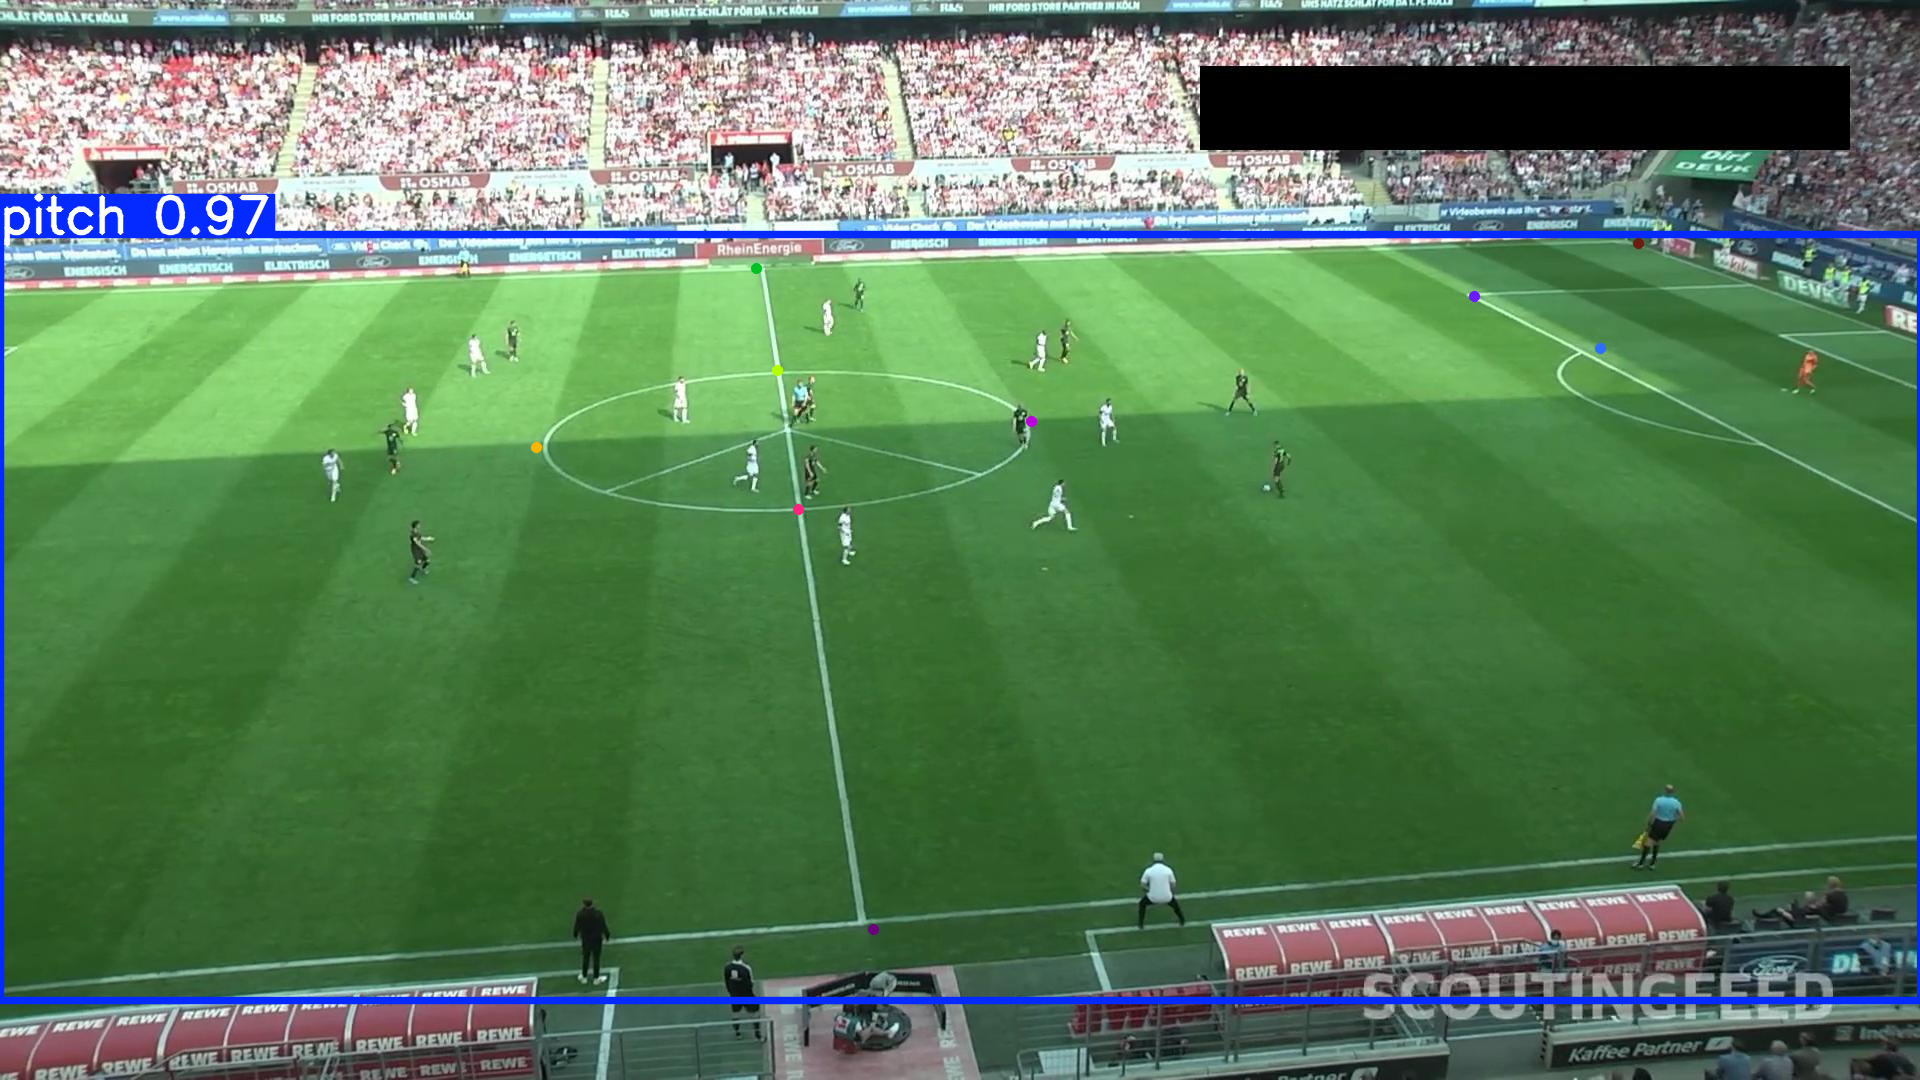

In [24]:
# Load the trained model
trained_model = YOLO(best_model_path)

# You can test the model on any football image
# If you have a test image, replace 'path/to/test/image.jpg' with the actual path
test_image = r"/home/asa/cvProj/foot/field-detection-dataset/test/images/42ba34_1_3_png.rf.2194b26cd44bdb486100a70a95a3ea67.jpg"
results = trained_model(test_image)
# results[0].show()  # Display the detection results

result_img = results[0].plot()

# Convert from BGR to RGB (OpenCV uses BGR by default)
image_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

# Convert numpy array to PIL Image
pil_img = PILImage.fromarray(image_rgb)

# Display using PIL
display(pil_img)

## Update Configuration for Local Inference

Update your local configuration to use this new model.

In [25]:
# To use this model in your main_test.py,
# update the MODEL_SRC variable in config.py to point to your newly trained model
print(f"To use this model in your application, update the MODEL_SRC variable in config.py to: {best_model_path}")

To use this model in your application, update the MODEL_SRC variable in config.py to: models/field_detector3/weights/best.pt
